# Translation with Transformer

- Download Dataset

In [2]:
from google.colab import drive
drive.mount('/gdrive')

import pandas as pd

from exp.nb_12a import *

from pathlib import Path
trg_path = Path('/gdrive/Shareddrives/Dion-Account/data')

In [3]:
trg_path.ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/data/giga-fren.tgz'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/data/giga-fren')]

In [ ]:
# !wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {trg_path}

In [ ]:
# !tar -xf {trg_path}/giga-fren.tgz -C {trg_path}

In [4]:
path = trg_path/'giga-fren'

In [ ]:
# with open(path/'giga-fren.release2.fixed.fr') as f: fr = f.read().split('\n')
# with open(path/'giga-fren.release2.fixed.en') as f: en = f.read().split('\n')
# import re
# re_eq = re.compile('^(Wh[^?.!]+\?)')
# re_fq = re.compile('^([^?.!]+\?)')
# lines = ((re_eq.search(eq), re_fq.search(fq))
#     for eq, fq, in zip(open(path/'giga-fren.release2.fixed.fr'), open(path/'giga-fren.release2.fixed.fr')))
# qs = [(e.group(), f.group()) for e, f in lines if e and f]
# import pandas as pd
# df = pd.DataFrame({'fr':[ q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr']) 
# df.to_csv(path/'question_easy.csv', index=False)

In [ ]:
df_load = pd.read_csv(path/'question_easy.csv')

In [ ]:
df_load.head()

,en,fr
0,What's at Stake for Developing Countries?,What's at Stake for Developing Countries?
1,What is the solution?,What is the solution?
2,Which of the following thoughts are likely to ...,Which of the following thoughts are likely to ...
3,Why does it always have to be my fault?,Why does it always have to be my fault?
4,Why can't she leave this alone?,Why can't she leave this alone?


## Positional Encoding

$$PE(pos,2i) =sin(pos/10000^{2i/d_{model}})$$  
$$PE(pos,2i+1) =cos(pos/10000^{2i/d_{model}})$$

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int):
        super().__init__()
        self.register_buffer('freq', 1/(10000 ** (torch.arange(0, d_model, 2.)/d_model)))
    def __call__(self, pos):
        inp = torch.outer(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [ ]:
positions = torch.arange(0, 100).float();# positions[:10]
d_model = 512

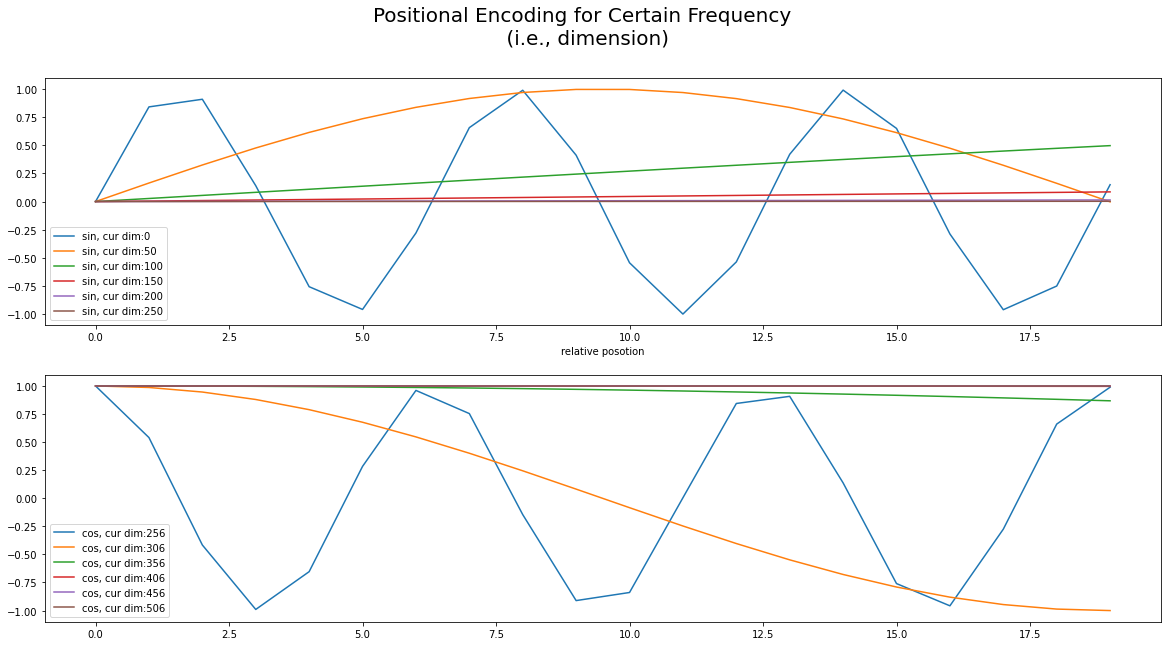

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1, figsize=(20,10))
fig.suptitle("Positional Encoding for Certain Frequency \n (i.e., dimension)", fontsize=20)

res = PositionalEncoding(d_model=d_model)(positions)
for i in range(0, d_model//2, 50):
    ax[0].plot(res[:20,i], label=f"sin, cur dim:{i}")
    ax[0].legend()
    ax[0].set_xlabel("relative posotion")
    ax[1].plot(res[:20,int(d_model/2+i)], label=f"cos, cur dim:{int(d_model/2+i)}"); ax[1].legend()


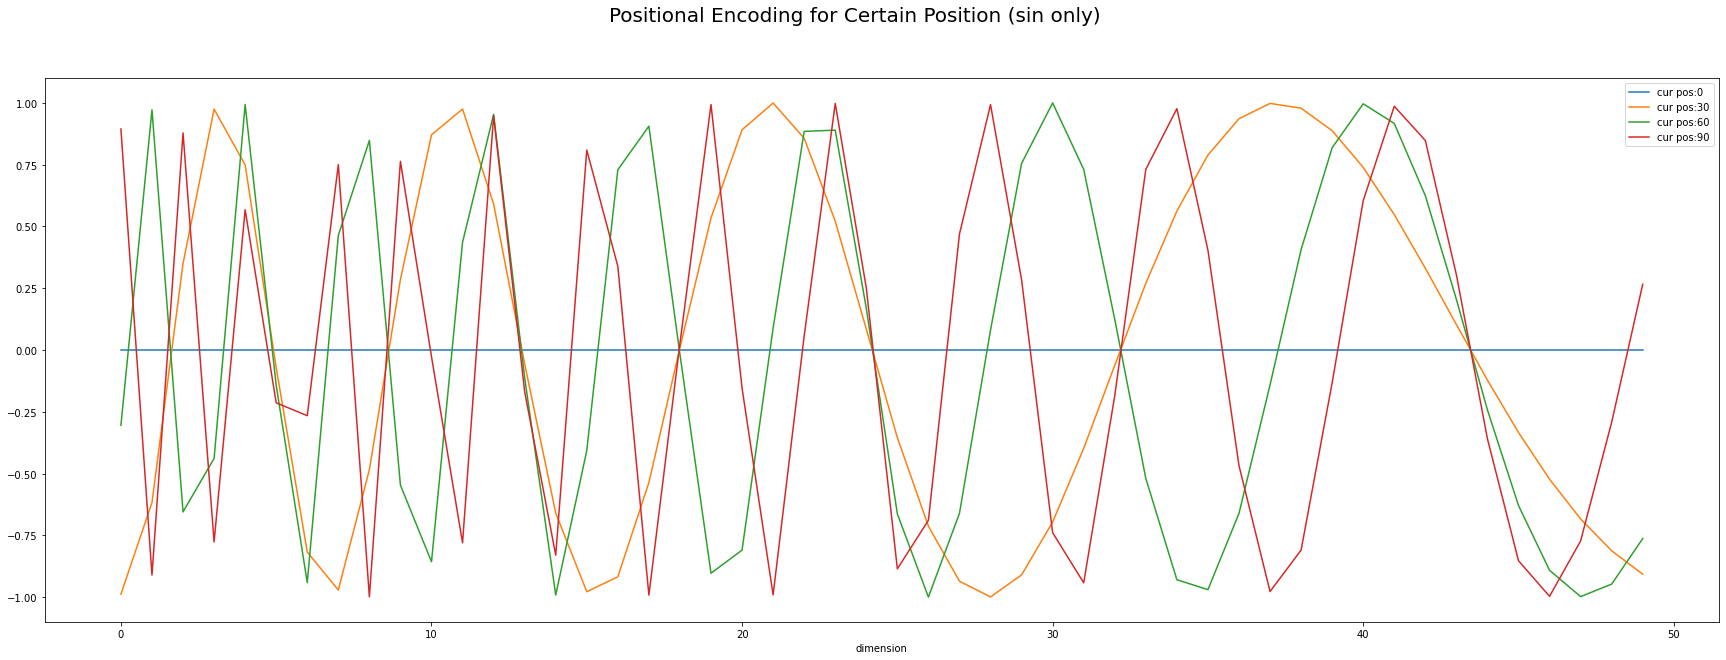

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(30,10))
fig.suptitle("Positional Encoding for Certain Position (sin only)", fontsize=20)

res = PositionalEncoding(d_model=d_model)(positions)
for i in range(0, 100, 30):
    ax.plot(res[i,:50], label=f"cur pos:{i}")
    ax.legend()
    ax.set_xlabel("dimension")

## TransformerEmbedding

In [ ]:
from torch import nn

In [ ]:
import math

class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size:int, emb_size:int, drop_p:float=0.):
        self.emb_size = emb_size
        self.embed = nn.Embedding(vocab_size, emb_size)
        self.pos_enc = PositionalEncoding(emb_size)
        self.dropout = nn.Droupout(drop_p)
        
    def forward(self, input):
        "input : sequence of indices of input sentence. e.g., [54, 23, 43, 12, 4, 4, 892, ...]"
        pos = torch.arange(0, input.size(1), device=input.device)
        return self.dropout(self.embed(input) * math.sqrt(self.emb_size) + self.pos_enc(pos))

## Feed-forward layer

In [ ]:
def feedforward(d_model:int, d_ff:int, ff_p=0., double_drop=None):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), Mergelayer(), nn.LayerNorm())


In [ ]:
class MergeLayer(nn.Module):
    "Merge a shortcut with the result of the module by adding them or concatenating them if `dense=True`."
    def __init__(self, dense:bool=False): self.dense=dense
    def forward(self, x): return torch.cat([x,x.orig], dim=1) if self.dense else (x+x.orig)

class SequentialEx(nn.Module):
    "Like `nn.Sequential`, but with ModuleList semantics, and can access module input"
    def __init__(self, *layers): self.layers = nn.ModuleList(layers)

    def forward(self, x):
        res = x
        for l in self.layers:
            res.orig = x
            nres = l(res)
            # We have to remove res.orig to avoid hanging refs and therefore memory leaks
            res.orig, nres.orig = None, None
            res = nres
        return res

    def __getitem__(self,i): return self.layers[i]
    def append(self,l):      return self.layers.append(l)
    def extend(self,l):      return self.layers.extend(l)
    def insert(self,i,l):    return self.layers.insert(i,l)

## Multi-head Attention

In [ ]:
# to enable type hint
from torch import *

In [ ]:
class MultiHeadAttention(nn.Module):
    "MutiHeadAttention."

    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        "Note that d_head can be decided arbitrarily"
        self.n_heads,self.d_head = n_heads,d_head
        self.q_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.k_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.v_wgt = nn.Linear(d_model, n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)
        
        self.scale = scale

    def forward(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, k, v, mask=mask))))

    def _apply_attention(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        """a shape of q, k, v is identical, which is (bs, seq_len, d_model)"""
        bs,seq_len = q.size(0),q.size(1)
        # Projection to dq, dk, and dv, where output tensor shape = (bs, seq_len, n_heads * d_head)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        # reshaping to (bs, seq_len, n_heads, d_head)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        # reshaping from      (bs, seq_len, n_heads, d_head) to
        # query:              (bs, n_heads, seq_len, d_head)
        # key:                (bs, n_heads, d_head, seq_len)
        # value:              (bs, n_heads, seq_len, d_head)
        wq,wk,wv = wq.permute(0, 2, 1, 3), wk.permute(0, 2, 3, 1), wv.permute(0, 2, 1, 3)
        #                     (bs x n_heads x seq_len x d_head)
        #              matmul (bs x n_heads x d_head x seq_len)
        # => attention score: (bs x n_heads x seq_len x seq_len)
        attn_score = torch.matmul(wq, wk)
        # if scale => div by sqrt of d_head
        if self.scale: attn_score = attn_score.div_(self.d_head ** 0.5)
        if mask is not None:
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        # (bs x n_heads x seq_len x seq_len),
        #       , where attn_prob[0,:,0] : (n_heads x seq_len)
        #           represents all scaling factors for one query(i.e., a word) with respect to all words in a sequence
        #  In other words, attn_prob[0,:,0] represents Figure 3 of Attention is all you need
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, seq_len, -1)

    def _attention_einsum(self, q:Tensor, k:Tensor, v:Tensor, mask:Tensor=None):
        # Sylvain Gugger: Permute and matmul is a little bit faster but this implementation is more readable
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = self.q_wgt(q),self.k_wgt(k),self.v_wgt(v)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        attn_score = torch.einsum('bind,bjnd->bijn', (wq, wk))
        if self.scale: attn_score = attn_score.mul_(1/(self.d_head ** 0.5))
        if mask is not None:
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=2))
        attn_vec = torch.einsum('bijn,bjnd->bind', (attn_prob, wv))
        return attn_vec.contiguous().view(bs, seq_len, -1)

In [16]:
bs, n_heads, d_head, seq_len = 32, 8, 512, 100
query=torch.randn(bs, n_heads, seq_len, d_head)
key = torch.randn(bs, n_heads, d_head, seq_len)
attn = torch.matmul(query, key)

In [17]:
attn_p = F.softmax(attn, dim=-1); attn_p.shape

torch.Size([32, 8, 100, 100])

In [12]:
attn_p.sum(-1, keepdim=True).shape

torch.Size([32, 8, 100, 1])

In [ ]:
attn_p[0, :, 0].shape

torch.Size([8, 100])

In [ ]:
attn_p.sum(-1)[:,:,-1].shape

torch.Size([32, 8])

In [ ]:
bs x n_heads x seq_len x seq_len